In [1]:
# Imports
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Import Data
df = pd.read_parquet('largeml.pq')

# Clean data
df['ret'] = pd.to_numeric(df['ret'], errors='coerce')  
df['yyyymm'] = df['yyyymm'].astype(int)
df['year_month'] = pd.to_datetime(df['yyyymm'], format='%Y%m')
df

,permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,...,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M,ret,year_month
0,10078,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.393044e-08,NaN,-0.118056,1986-06-01
1,10078,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.737205e-08,NaN,-0.039370,1986-07-01
2,10078,198609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.597698e-08,1.857281e-07,-0.008850,1986-09-01
3,10078,198610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.763825e-08,2.111030e-07,0.348214,1986-10-01
4,10078,198612,0.236302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.718727,NaN,5.878542e-09,8.619326e-08,0.109827,1986-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79141,93436,202206,0.088628,-2.813974,0.11705,0.115017,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.035232,NaN,0.707502,1.469368e-08,3.335508e-09,2.833702e-08,-0.111888,2022-06-01
79142,93436,202208,0.071943,-2.813974,0.11705,0.115017,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.021508,NaN,0.707502,1.432295e-08,3.931841e-09,2.786815e-08,-0.072489,2022-08-01
79143,93436,202209,0.074172,-2.813974,0.11705,0.115017,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.041281,NaN,0.707502,1.392299e-08,3.530526e-09,2.626227e-08,-0.037589,2022-09-01
79144,93436,202210,0.086471,-2.813974,0.11705,0.115017,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.025198,NaN,0.707502,1.386902e-08,5.036988e-09,2.783926e-08,-0.142168,2022-10-01


# 1. Monthly returns for large-cap and small-cap stocks

## (a) Rank-Sort Characteristics Cross-Sectionally for Each Month

In [3]:
# Exclude certain columns
exclude_cols = ['permno', 'yyyymm', 'year_month', 'ret', 'date']
characteristic_cols = [col for col in df.columns if col not in exclude_cols]

# Create ranks
df_ranks = df[['permno', 'year_month', 'ret']].copy()

for char in characteristic_cols:
    df_ranks[char + "_rank"] = (
        df.groupby('year_month')[char]
          .rank(pct=True, na_option='keep') * 100
    )

df_ranks.head()

/var/folders/rp/39_89_qs577cxcr_85qc9jnw0000gn/T/ipykernel_62858/4054060536.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ranks[char + "_rank"] = (
/var/folders/rp/39_89_qs577cxcr_85qc9jnw0000gn/T/ipykernel_62858/4054060536.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ranks[char + "_rank"] = (
/var/folders/rp/39_89_qs577cxcr_85qc9jnw0000gn/T/ipykernel_62858/4054060536.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

,permno,year_month,ret,AM_rank,AOP_rank,AbnormalAccruals_rank,Accruals_rank,AccrualsBM_rank,Activism1_rank,Activism2_rank,...,retConglomerate_rank,roaq_rank,sfe_rank,sinAlgo_rank,skew1_rank,std_turn_rank,tang_rank,zerotrade12M_rank,zerotrade1M_rank,zerotrade6M_rank
0,10078,1986-06-01,-0.118056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.086420,NaN
1,10078,1986-07-01,-0.039370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.750000,NaN
2,10078,1986-09-01,-0.008850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,29.113924
3,10078,1986-10-01,0.348214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.750000,37.500000
4,10078,1986-12-01,0.109827,5.555556,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,2.439024,6.329114


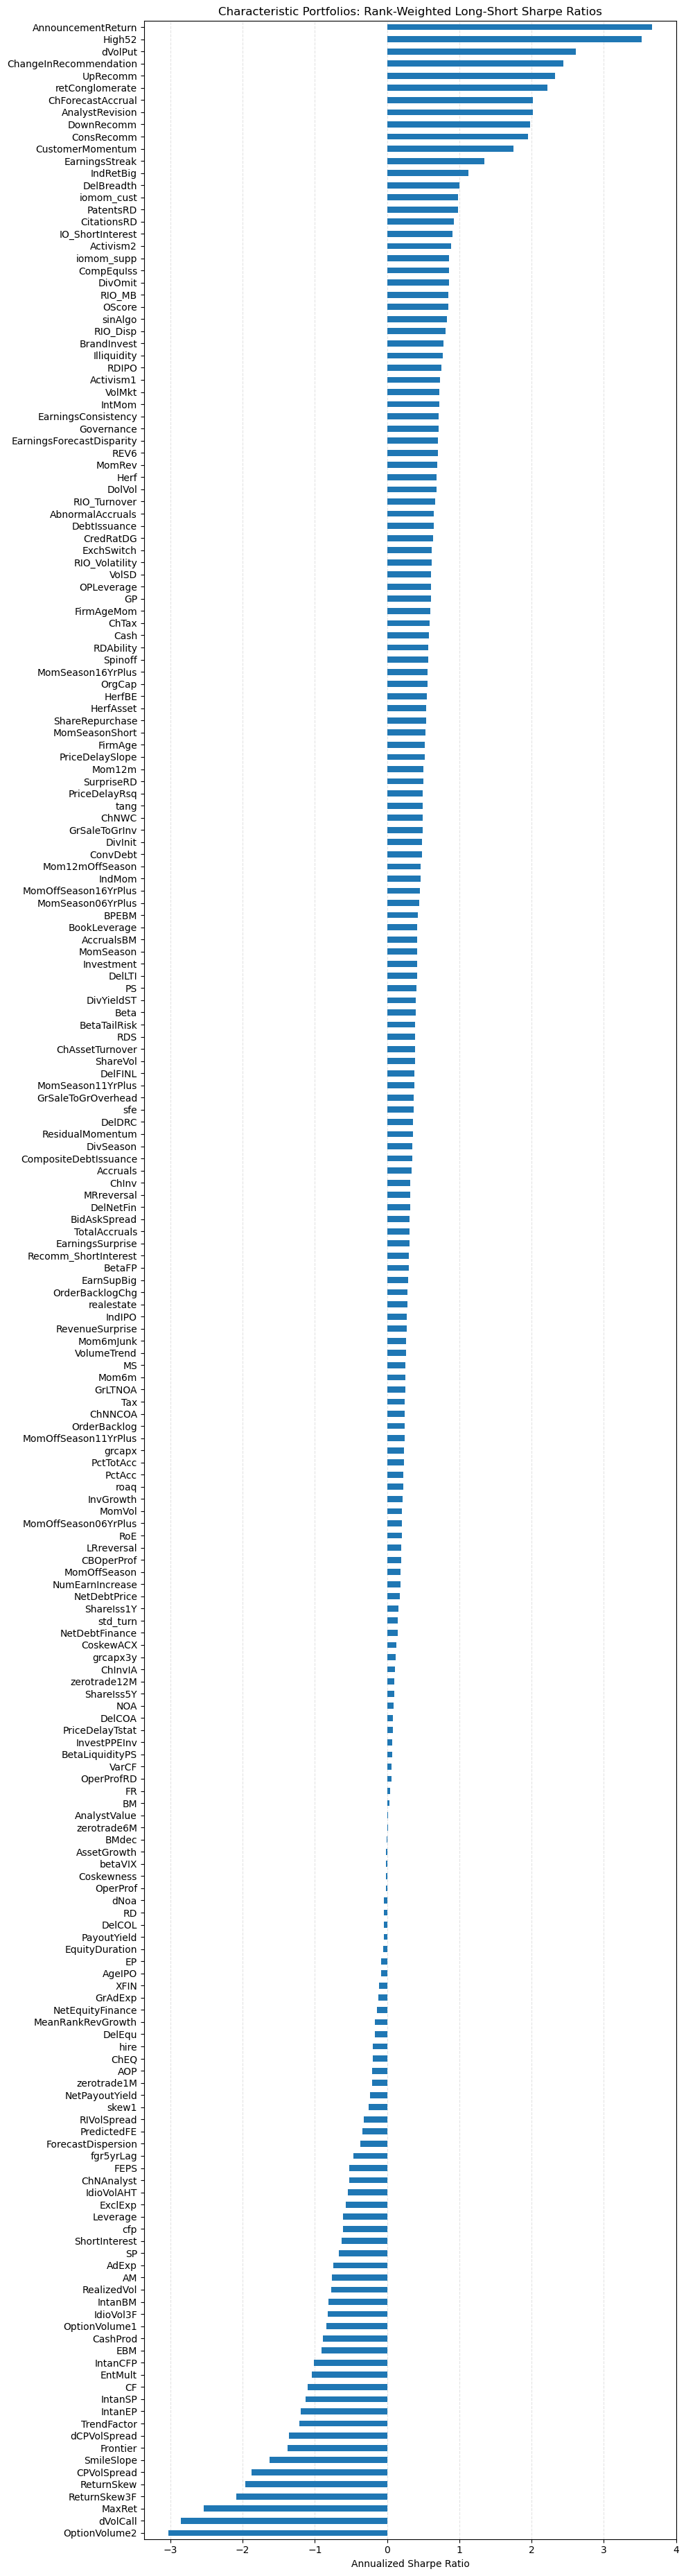

In [4]:
# Build portfolio return series for EVERY characteristic
# (Make this cell runnable even if you didn't run prior cells)
rank_cols = [c for c in df_ranks.columns if c.endswith('_rank')]

if 'characteristic_portfolio_returns' not in globals():
    def characteristic_portfolio_returns(df_ranks, rank_col, date_col="year_month", ret_col="ret"):
        tmp = df_ranks[[date_col, ret_col, rank_col]].dropna(subset=[ret_col, rank_col]).copy()
        tmp["w"] = tmp[rank_col] / 100.0 - 0.5
        tmp["wr"] = tmp["w"] * tmp[ret_col]
        tmp["absw"] = tmp["w"].abs()
        g = tmp.groupby(date_col, sort=True)
        return g["wr"].sum() / g["absw"].sum()

port_rets = {}
for rc in rank_cols:
    port_rets[rc.replace("_rank","")] = characteristic_portfolio_returns(df_ranks, rc)

# Convert dict of Series to DataFrame, aligning by index
port_rets = pd.concat(port_rets, axis=1).sort_index()
port_rets.head()

# Compute Annualized Sharpe ratios
sharpe = port_rets.mean() / port_rets.std(ddof=1) * np.sqrt(12)
sharpe = sharpe.dropna().sort_values()

# Plot Sharpe ratios
plt.figure(figsize=(10, max(6, 0.18 * len(sharpe))))
ax = sharpe.plot(kind="barh")
ax.set_axisbelow(True)
ax.grid(axis="x", linestyle="--", alpha=0.35)
plt.xlabel("Annualized Sharpe Ratio")
plt.title("Characteristic Portfolios: Rank-Weighted Long-Short Sharpe Ratios")
plt.tight_layout()
plt.show()


## Analysis

Very few characteristics have a significantly positive sharpe ratio with only 13 characteristics with a sharpe ratio > 1. 

Characteristics related to information flow and short-term news, such as announcement returns, analyst recommendation changes, and forecast revisions, achieve the highest Sharpe ratios, indicating strong predictive power for future returns. In contrast, many traditional accounting-based characteristics exhibit Sharpe ratios close to zero, particularly in this large-cap sample.

## (b) Adding Machine Learning Methods

In [5]:
warnings.filterwarnings("ignore")

df_ml = df.copy()
df_ml = df_ml.sort_values("year_month").reset_index(drop=True)

# Ensure numeric
df_ml["ret"] = pd.to_numeric(df_ml["ret"], errors="coerce")
df_ml[characteristic_cols] = df_ml[characteristic_cols].apply(pd.to_numeric, errors="coerce")

# Only drop rows where returns are NaN
df_ml = df_ml.dropna(subset=["ret"]).copy()

# Cross-sectional rank-normalize characteristics each month to [-0.5, 0.5]
df_ml[characteristic_cols] = (
    df_ml.groupby("year_month")[characteristic_cols]
         .rank(pct=True, na_option="keep")
    - 0.5
)

# Define train/validation/test split points (by year-month)
unique_months = sorted(df_ml["year_month"].dropna().unique())
total_months = len(unique_months)

train_end_idx = 20 * 12
val_end_idx = train_end_idx + 12 * 12

# Use idx-1 so train is exactly 240 months (same for validation)
train_end_date = unique_months[min(train_end_idx - 1, total_months - 1)]
val_end_date   = unique_months[min(val_end_idx   - 1, total_months - 1)]

# Create boolean masks for train/val/test
train_mask = df_ml["year_month"] <= train_end_date
val_mask   = (df_ml["year_month"] > train_end_date) & (df_ml["year_month"] <= val_end_date)
test_mask  = df_ml["year_month"] > val_end_date

# Extract data
X_train_raw = df_ml.loc[train_mask, characteristic_cols].values
y_train = df_ml.loc[train_mask, "ret"].values

X_val_raw = df_ml.loc[val_mask, characteristic_cols].values
y_val = df_ml.loc[val_mask, "ret"].values

X_test_raw = df_ml.loc[test_mask, characteristic_cols].values
y_test = df_ml.loc[test_mask, "ret"].values

# Impute missing ranks with 0 (middle of the cross-section); no StandardScaler needed now
imputer = SimpleImputer(strategy="constant", fill_value=0.0)
X_train_scaled = imputer.fit_transform(X_train_raw)
X_val_scaled   = imputer.transform(X_val_raw)
X_test_scaled  = imputer.transform(X_test_raw)

In [6]:
# Helper function to evaluate model

def r2_oos_finance(y_true, y_pred, y_train_ref, benchmark="train_mean"):
    sse_model = np.sum((y_true - y_pred) ** 2)
    if benchmark == "zero":
        sse_bench = np.sum((y_true) ** 2)
    elif benchmark == "train_mean":
        mu = np.mean(y_train_ref)
        sse_bench = np.sum((y_true - mu) ** 2)
    else:
        raise ValueError("benchmark must be 'train_mean' or 'zero'")
    return 1 - sse_model / sse_bench

def evaluate_model_oos(model_name, model, X_train, X_val, X_test, y_train, y_val, y_test, results_dict=None, benchmark="train_mean"):

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)
    y_test_pred  = model.predict(X_test)

    # Metrics
    metrics = {
        # statistical (sklearn) R²
        "r2_train": r2_score(y_train, y_train_pred),
        "r2_val":   r2_score(y_val,   y_val_pred),
        "r2_test_sklearn": r2_score(y_test, y_test_pred),

        # finance OOS R² (Campbell–Thompson style)
        "r2_oos_val":  r2_oos_finance(y_val,  y_val_pred,  y_train, benchmark=benchmark),
        "r2_oos_test": r2_oos_finance(y_test, y_test_pred, y_train, benchmark=benchmark),

        # RMSE
        "rmse_train": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "rmse_val":   np.sqrt(mean_squared_error(y_val,   y_val_pred)),
        "rmse_test":  np.sqrt(mean_squared_error(y_test,  y_test_pred)),

        "model": model,
    }

    # Print results
    print(f"\nMODEL: {model_name}")

    print("\nIn-Sample:")
    print(f"  R² (sklearn): {metrics['r2_train']:10.6f}")
    print(f"  RMSE:         {metrics['rmse_train']:10.6f}")

    print("\nValidation Performance:")
    print(f"  R² (sklearn): {metrics['r2_val']:10.6f}")
    print(f"  R²_OOS ({benchmark}): {metrics['r2_oos_val']:10.6f}")
    print(f"  RMSE:         {metrics['rmse_val']:10.6f}")

    print("\nOOS:")
    print(f"  R²_OOS ({benchmark}): {metrics['r2_oos_test']:10.6f}")
    print(f"  RMSE:         {metrics['rmse_test']:10.6f}")

    # Store
    if results_dict is not None:
        results_dict[model_name] = metrics

    return metrics


### (i) OLS over the linear characteristics

In [7]:
# Initialize results dictionary
results = {}

BENCHMARK = "train_mean"

# OLS
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

evaluate_model_oos(
    "OLS",
    ols_model,
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)



MODEL: OLS

In-Sample:
  R² (sklearn):   0.128515
  RMSE:           0.077815

Validation Performance:
  R² (sklearn):   0.012427
  R²_OOS (train_mean):   0.021225
  RMSE:           0.062253

OOS:
  R²_OOS (train_mean):  -0.005917
  RMSE:           0.104401


{'r2_train': 0.12851499713269798,
 'r2_val': 0.012426564403921536,
 'r2_test_sklearn': -0.009479368295470803,
 'r2_oos_val': np.float64(0.021225345241641103),
 'r2_oos_test': np.float64(-0.005916734335721152),
 'rmse_train': np.float64(0.07781454303901687),
 'rmse_val': np.float64(0.06225339861502619),
 'rmse_test': np.float64(0.10440066015462132),
 'model': LinearRegression()}

### (ii) Lasso/ridge/elastic net over the linear characteristics.

In [8]:
# Lasso/Ridge/ElasticNet - no GridSearchCV

# Lasso
lasso_model = Lasso(0.1)
lasso_model.fit(X_train_scaled, y_train)

evaluate_model_oos(
    "Lasso",
    lasso_model,
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

# Ridge
ridge_model = Ridge(1.0)
ridge_model.fit(X_train_scaled, y_train)

evaluate_model_oos(
    "Ridge",
    ridge_model,
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

# Elastic Net
enet_model = ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=20000, random_state=0)
enet_model.fit(X_train_scaled, y_train)

evaluate_model_oos(
    "Elastic Net",
    enet_model,
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)


MODEL: Lasso

In-Sample:
  R² (sklearn):   0.000000
  RMSE:           0.083355

Validation Performance:
  R² (sklearn):  -0.008990
  R²_OOS (train_mean):   0.000000
  RMSE:           0.062925

OOS:
  R²_OOS (train_mean):   0.000000
  RMSE:           0.104093

MODEL: Ridge

In-Sample:
  R² (sklearn):   0.126493
  RMSE:           0.077905

Validation Performance:
  R² (sklearn):   0.103406
  R²_OOS (train_mean):   0.111394
  RMSE:           0.059317

OOS:
  R²_OOS (train_mean):   0.112614
  RMSE:           0.098057

MODEL: Elastic Net

In-Sample:
  R² (sklearn):   0.097250
  RMSE:           0.079198

Validation Performance:
  R² (sklearn):   0.167774
  R²_OOS (train_mean):   0.175189
  RMSE:           0.057148

OOS:
  R²_OOS (train_mean):   0.131948
  RMSE:           0.096983


{'r2_train': 0.09724993398282122,
 'r2_val': 0.1677741154572121,
 'r2_test_sklearn': 0.12887337299484425,
 'r2_oos_val': np.float64(0.17518882802605462),
 'r2_oos_test': np.float64(0.13194773528701376),
 'rmse_train': np.float64(0.07919806610702439),
 'rmse_val': np.float64(0.05714772891340385),
 'rmse_test': np.float64(0.09698289982339255),
 'model': ElasticNet(alpha=0.001, max_iter=20000, random_state=0)}

In [9]:
def grid_search_on_val(model_cls, param_grid, model_name, X_train, y_train, X_val, y_val, benchmark="train_mean"):
    best = None
    for params in ParameterGrid(param_grid):
        model = model_cls(**params)
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        score = float(r2_oos_finance(y_val, y_val_pred, y_train, benchmark=benchmark))

        if (best is None) or (score > best["r2_oos_val"]):
            best = {"model_name": model_name, "params": params, "r2_oos_val": score, "model": model}

    print(model_name, "best:", best["params"], "val R2_OOS:", best["r2_oos_val"])
    return best

# Grids (adjust ranges if everything collapses to ~0)
ridge_best = grid_search_on_val(
    Ridge,
    {"alpha": np.logspace(-5, 5, 25)},
    "Ridge",
    X_train_scaled,
    y_train,
    X_val_scaled,
    y_val,
    benchmark=BENCHMARK,
)

lasso_best = grid_search_on_val(
    Lasso,
    {"alpha": np.logspace(-6, -1, 25), "max_iter": [50000]},
    "Lasso",
    X_train_scaled,
    y_train,
    X_val_scaled,
    y_val,
    benchmark=BENCHMARK,
)

enet_best = grid_search_on_val(
    ElasticNet,
    {"alpha": np.logspace(-6, -1, 25), "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], "max_iter": [50000]},
    "ElasticNet",
    X_train_scaled,
    y_train,
    X_val_scaled,
    y_val,
    benchmark=BENCHMARK,
)

# Evaluate
evaluate_model_oos(
    "Ridge(best)",
    ridge_best["model"],
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

evaluate_model_oos(
    "Lasso(best)",
    lasso_best["model"],
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

evaluate_model_oos(
    "ElasticNet(best)",
    enet_best["model"],
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)


Ridge best: {'alpha': np.float64(17.78279410038923)} val R2_OOS: 0.17313217095401456
Lasso best: {'alpha': np.float64(0.00019573417814876617), 'max_iter': 50000} val R2_OOS: 0.17951682855369744
ElasticNet best: {'alpha': np.float64(0.0021544346900318843), 'l1_ratio': 0.1, 'max_iter': 50000} val R2_OOS: 0.18037029119375725

MODEL: Ridge(best)

In-Sample:
  R² (sklearn):   0.112994
  RMSE:           0.078504

Validation Performance:
  R² (sklearn):   0.165699
  R²_OOS (train_mean):   0.173132
  RMSE:           0.057219

OOS:
  R²_OOS (train_mean):   0.127053
  RMSE:           0.097256

MODEL: Lasso(best)

In-Sample:
  R² (sklearn):   0.112876
  RMSE:           0.078510

Validation Performance:
  R² (sklearn):   0.172141
  R²_OOS (train_mean):   0.179517
  RMSE:           0.056998

OOS:
  R²_OOS (train_mean):   0.143271
  RMSE:           0.096348

MODEL: ElasticNet(best)

In-Sample:
  R² (sklearn):   0.109470
  RMSE:           0.078660

Validation Performance:
  R² (sklearn):   0.173002
 

{'r2_train': 0.10947041005595326,
 'r2_val': 0.17300215784374684,
 'r2_test_sklearn': 0.13797841971429414,
 'r2_oos_val': np.float64(0.18037029119375725),
 'r2_oos_test': np.float64(0.141020648661626),
 'rmse_train': np.float64(0.07866018975597823),
 'rmse_val': np.float64(0.056967945122940684),
 'rmse_test': np.float64(0.09647473412193829),
 'model': ElasticNet(alpha=np.float64(0.0021544346900318843), l1_ratio=0.1,
            max_iter=50000)}

### (iii) Lasso/ridge/elastic net over the non-linear expansion formed by RBFSampler

In [10]:

# RBF features
rbf_transformer = RBFSampler(n_components=100, gamma=1.0, random_state=42)
X_train_rbf = rbf_transformer.fit_transform(X_train_scaled)
X_val_rbf = rbf_transformer.transform(X_val_scaled)
X_test_rbf = rbf_transformer.transform(X_test_scaled)

# Grid search ON the RBF features (important: pass X_train_rbf / X_val_rbf)
ridge_rbf_best = grid_search_on_val(
    Ridge,
    {"alpha": np.logspace(-5, 5, 25)},
    "Ridge+RBF",
    X_train_rbf,
    y_train,
    X_val_rbf,
    y_val,
    benchmark=BENCHMARK,
)

lasso_rbf_best = grid_search_on_val(
    Lasso,
    {"alpha": np.logspace(-6, -1, 25), "max_iter": [50000]},
    "Lasso+RBF",
    X_train_rbf,
    y_train,
    X_val_rbf,
    y_val,
    benchmark=BENCHMARK,
)

enet_rbf_best = grid_search_on_val(
    ElasticNet,
    {"alpha": np.logspace(-6, -1, 25), "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], "max_iter": [50000]},
    "ElasticNet+RBF",
    X_train_rbf,
    y_train,
    X_val_rbf,
    y_val,
    benchmark=BENCHMARK,
)

# Evaluate
evaluate_model_oos(
    "Ridge+RBF(best)",
    ridge_rbf_best["model"],
    X_train_rbf,
    X_val_rbf,
    X_test_rbf,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

evaluate_model_oos(
    "Lasso+RBF(best)",
    lasso_rbf_best["model"],
    X_train_rbf,
    X_val_rbf,
    X_test_rbf,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

evaluate_model_oos(
    "ElasticNet+RBF(best)",
    enet_rbf_best["model"],
    X_train_rbf,
    X_val_rbf,
    X_test_rbf,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

Ridge+RBF best: {'alpha': np.float64(316.22776601683796)} val R2_OOS: 0.00019524664454750873
Lasso+RBF best: {'alpha': np.float64(0.000825404185268019), 'max_iter': 50000} val R2_OOS: 0.0
ElasticNet+RBF best: {'alpha': np.float64(0.000825404185268019), 'l1_ratio': 0.9, 'max_iter': 50000} val R2_OOS: 0.0

MODEL: Ridge+RBF(best)

In-Sample:
  R² (sklearn):   0.005781
  RMSE:           0.083114

Validation Performance:
  R² (sklearn):  -0.008793
  R²_OOS (train_mean):   0.000195
  RMSE:           0.062919

OOS:
  R²_OOS (train_mean):  -0.000155
  RMSE:           0.104101

MODEL: Lasso+RBF(best)

In-Sample:
  R² (sklearn):   0.000000
  RMSE:           0.083355

Validation Performance:
  R² (sklearn):  -0.008990
  R²_OOS (train_mean):   0.000000
  RMSE:           0.062925

OOS:
  R²_OOS (train_mean):   0.000000
  RMSE:           0.104093

MODEL: ElasticNet+RBF(best)

In-Sample:
  R² (sklearn):   0.000000
  RMSE:           0.083355

Validation Performance:
  R² (sklearn):  -0.008990
  R²_OOS

{'r2_train': 0.0,
 'r2_val': -0.00898958794544158,
 'r2_test_sklearn': -0.0035416787872628586,
 'r2_oos_val': np.float64(0.0),
 'r2_oos_test': np.float64(0.0),
 'rmse_train': np.float64(0.08335483813553872),
 'rmse_val': np.float64(0.0629247803941597),
 'rmse_test': np.float64(0.10409316850829943),
 'model': ElasticNet(alpha=np.float64(0.000825404185268019), l1_ratio=0.9, max_iter=50000)}

### (iv) PLSRegression over the linear characteristics and the non-linear expansion


In [11]:
# Linear
pls_best = grid_search_on_val(
    PLSRegression,
    {"n_components": list(range(1, min(50, X_train_scaled.shape[1]) + 1, 5))},
    "PLS(Linear)",
    X_train_scaled,
    y_train,
    X_val_scaled,
    y_val,
    benchmark=BENCHMARK,
)

evaluate_model_oos(
    "PLS(linear)",
    pls_best["model"],
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

# Non-Linear expansion

rbf_transformer = RBFSampler(n_components=100, gamma=1.0, random_state=42)
X_train_rbf = rbf_transformer.fit_transform(X_train_scaled)
X_val_rbf = rbf_transformer.transform(X_val_scaled)
X_test_rbf = rbf_transformer.transform(X_test_scaled)

X_train_combined = np.concatenate([X_train_scaled, X_train_rbf], axis=1)
X_val_combined = np.concatenate([X_val_scaled, X_val_rbf], axis=1)
X_test_combined = np.concatenate([X_test_scaled, X_test_rbf], axis=1)

pls_rbf_best = grid_search_on_val(
    PLSRegression,
    {"n_components": list(range(1, min(50, X_train_combined.shape[1]) + 1, 5))},
    # Try [1, 6, 11, 16, 21, 26, 31, 36, 41, 46] components
    "PLS(linear+RBF)",
    X_train_combined,
    y_train,
    X_val_combined,
    y_val,
    benchmark=BENCHMARK,
)

evaluate_model_oos(
    "PLS(linear+RBF)(best)",
    pls_rbf_best["model"],
    X_train_combined,
    X_val_combined,
    X_test_combined,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

PLS(Linear) best: {'n_components': 1} val R2_OOS: 0.0695524536692036

MODEL: PLS(linear)

In-Sample:
  R² (sklearn):   0.067940
  RMSE:           0.080473

Validation Performance:
  R² (sklearn):   0.061188
  R²_OOS (train_mean):   0.069552
  RMSE:           0.060697

OOS:
  R²_OOS (train_mean):   0.081842
  RMSE:           0.099743
PLS(linear+RBF) best: {'n_components': 1} val R2_OOS: 0.024797548755539744

MODEL: PLS(linear+RBF)(best)

In-Sample:
  R² (sklearn):   0.117866
  RMSE:           0.078289

Validation Performance:
  R² (sklearn):   0.016031
  R²_OOS (train_mean):   0.024798
  RMSE:           0.062140

OOS:
  R²_OOS (train_mean):   0.071245
  RMSE:           0.100317


{'r2_train': 0.11786633827219484,
 'r2_val': 0.01603088055546742,
 'r2_test_sklearn': 0.06795554805591997,
 'r2_oos_val': np.float64(0.024797548755539744),
 'r2_oos_test': np.float64(0.07124490029112107),
 'rmse_train': np.float64(0.07828850681535092),
 'rmse_val': np.float64(0.06213969262339869),
 'rmse_test': np.float64(0.10031660685873903),
 'model': PLSRegression(n_components=1)}

### (v) GradientBoostingRegressor

In [12]:
gb_best = grid_search_on_val(
    GradientBoostingRegressor,
    {
        "n_estimators": [50, 100, 200],          
        "learning_rate": [0.01, 0.05, 0.1],       
        "max_depth": [3, 5, 7],                  
        "min_samples_split": [20, 50, 100],       
        "subsample": [0.8, 1.0],                  
        "random_state": [42]                    
    },
    "GradientBoosting",
    X_train_scaled,
    y_train,
    X_val_scaled,
    y_val,
    benchmark=BENCHMARK,
)

# Evaluate
evaluate_model_oos(
    "GradientBoosting(best)",
    gb_best["model"],
    X_train_scaled,
    X_val_scaled,
    X_test_scaled,
    y_train,
    y_val,
    y_test,
    results,
    benchmark=BENCHMARK,
)

GradientBoosting best: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 100, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.8} val R2_OOS: 0.18769812255362328

MODEL: GradientBoosting(best)

In-Sample:
  R² (sklearn):   0.296131
  RMSE:           0.069932

Validation Performance:
  R² (sklearn):   0.180396
  R²_OOS (train_mean):   0.187698
  RMSE:           0.056713

OOS:
  R²_OOS (train_mean):   0.128211
  RMSE:           0.097191


{'r2_train': 0.2961311807065038,
 'r2_val': 0.18039586338807168,
 'r2_test_sklearn': 0.12512355312808054,
 'r2_oos_val': np.float64(0.18769812255362328),
 'r2_oos_test': np.float64(0.12821114920790322),
 'rmse_train': np.float64(0.06993211706523231),
 'rmse_val': np.float64(0.05671271478400755),
 'rmse_test': np.float64(0.09719141020228197),
 'model': GradientBoostingRegressor(learning_rate=0.05, min_samples_split=100,
                           random_state=42, subsample=0.8)}

In [13]:
# Present results in a df

rows = []
for name, metrics in results.items():
    row = {"model": name}

    for k, v in metrics.items():
        if k == "model":
            row["estimator"] = type(v).__name__
            row["params"] = getattr(v, "get_params", lambda: {})()
        else:
            row[k] = float(v) if isinstance(v, (np.floating, np.integer)) else v

    rows.append(row)

df_results = pd.DataFrame(rows)

# Put the most common columns first (others will follow)
first_cols = [c for c in ["model", "estimator", "r2_oos_test", "r2_oos_val", "r2_test_sklearn", "r2_val", "r2_train",
                          "rmse_test", "rmse_val", "rmse_train", "params"] if c in df_results.columns]
df_results = df_results[first_cols + [c for c in df_results.columns if c not in first_cols]]

# Sort best-to-worst (change key if you want)
sort_key = "r2_oos_test" if "r2_oos_test" in df_results.columns else "r2_oos_val"
df_results = df_results.sort_values(sort_key, ascending=False).reset_index(drop=True)

df_results


,model,estimator,r2_oos_test,r2_oos_val,r2_test_sklearn,r2_val,r2_train,rmse_test,rmse_val,rmse_train,params
0,Lasso(best),Lasso,0.143271,0.179517,0.140237,0.172141,0.112876,0.096348,0.056998,0.078510,"{'alpha': 0.00019573417814876617, 'copy_X': Tr..."
1,ElasticNet(best),ElasticNet,0.141021,0.180370,0.137978,0.173002,0.109470,0.096475,0.056968,0.078660,"{'alpha': 0.0021544346900318843, 'copy_X': Tru..."
2,Elastic Net,ElasticNet,0.131948,0.175189,0.128873,0.167774,0.097250,0.096983,0.057148,0.079198,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep..."
3,GradientBoosting(best),GradientBoostingRegressor,0.128211,0.187698,0.125124,0.180396,0.296131,0.097191,0.056713,0.069932,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
4,Ridge(best),Ridge,0.127053,0.173132,0.123961,0.165699,0.112994,0.097256,0.057219,0.078504,"{'alpha': 17.78279410038923, 'copy_X': True, '..."
5,Ridge,Ridge,0.112614,0.111394,0.109471,0.103406,0.126493,0.098057,0.059317,0.077905,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'..."
6,PLS(linear),PLSRegression,0.081842,0.069552,0.078590,0.061188,0.067940,0.099743,0.060697,0.080473,"{'copy': True, 'max_iter': 500, 'n_components'..."
7,PLS(linear+RBF)(best),PLSRegression,0.071245,0.024798,0.067956,0.016031,0.117866,0.100317,0.062140,0.078289,"{'copy': True, 'max_iter': 500, 'n_components'..."
8,Lasso,Lasso,0.000000,0.000000,-0.003542,-0.008990,0.000000,0.104093,0.062925,0.083355,"{'alpha': 0.1, 'copy_X': True, 'fit_intercept'..."
9,Lasso+RBF(best),Lasso,0.000000,0.000000,-0.003542,-0.008990,0.000000,0.104093,0.062925,0.083355,"{'alpha': 0.000825404185268019, 'copy_X': True..."


## Analysis

The best model seems to be Lasso with an OOS R^2 of 0.14.  

Most of the models have R^2 close to 0. We can assume this to be normal because stock returns are extremely noisy. The models are likely overfitting the data. We can see this in OLS, which has the lowest R^2. It is also important to note that the time-split may be impacting the models performance. We use the first 20 years to train, the next 12 to validate, and the rest to test. However, the market has changed a lot since those first 20 years. In between the training and the testing there have been many financial crises, tech bubbles, and policy changes. 


## (c) Forming a portolfio for each method

In [14]:
# helpers
def long_short_portfolio_returns(df_scores, score_col, date_col="year_month", ret_col="ret"):
    tmp = df_scores[[date_col, ret_col, score_col]].dropna().copy()
    tmp["rank"] = tmp.groupby(date_col)[score_col].rank(pct=True)
    tmp["w"] = tmp["rank"] - 0.5
    tmp["wr"] = tmp["w"] * tmp[ret_col]
    tmp["absw"] = tmp["w"].abs()
    g = tmp.groupby(date_col, sort=True)
    return g["wr"].sum() / g["absw"].sum()

def ann_sharpe(x):
    x = pd.Series(x).dropna()
    return (x.mean() / x.std(ddof=1)) * np.sqrt(12)

# test-period panel aligned with X_test_* row order
df_test = df_ml.loc[test_mask, ["permno", "year_month", "ret"]].copy().reset_index(drop=True)
df_test["ret"] = pd.to_numeric(df_test["ret"], errors="coerce")
df_test = df_test.dropna(subset=["ret"]).reset_index(drop=True)

# build RBF / combined features (if needed) using the same transformer fit on train
if "rbf_transformer" not in globals():
    rbf_transformer = RBFSampler(n_components=100, gamma=1.0, random_state=42)
    _ = rbf_transformer.fit_transform(X_train_scaled)

X_test_rbf = rbf_transformer.transform(X_test_scaled)
X_test_combined = np.hstack([X_test_scaled, X_test_rbf])

def X_for_model_name(name):
    n = name.lower()
    if "linear+rbf" in n or "combined" in n:
        return X_test_combined
    if "rbf" in n:
        return X_test_rbf
    return X_test_scaled

# ML portfolios
ml_port_rets = {}
for model_name, m in results.items():
    model = m["model"]
    X_use = X_for_model_name(model_name)
    preds = model.predict(X_use)
    preds = np.asarray(preds).ravel()

    df_scores = df_test.copy()
    df_scores["score"] = preds
    ml_port_rets[model_name] = long_short_portfolio_returns(df_scores, "score")

ml_port_rets = pd.DataFrame(ml_port_rets).sort_index()
ml_sharpe = (ml_port_rets.apply(ann_sharpe)).sort_values(ascending=False)

# Sharpe over same test period 
test_months = ml_port_rets.index
char_port_rets_test = port_rets.loc[port_rets.index.intersection(test_months)].copy()
char_sharpe = (char_port_rets_test.apply(ann_sharpe)).sort_values(ascending=False)

# comparison tables
df_ml_sharpe = ml_sharpe.rename("ann_sharpe").to_frame()
df_char_sharpe = char_sharpe.rename("ann_sharpe").to_frame()

print("Top ML portfolios (annualized Sharpe):")
display(df_ml_sharpe)

print("Top characteristic portfolios over same period (annualized Sharpe):")
display(df_char_sharpe.head(20))


Top ML portfolios (annualized Sharpe):


,ann_sharpe
Elastic Net,8.280996
Lasso(best),8.164888
ElasticNet(best),8.137065
Ridge(best),7.969275
Ridge,7.227631
GradientBoosting(best),6.925476
OLS,5.879208
PLS(linear),5.074215
PLS(linear+RBF)(best),4.712576
Lasso,1.085946


Top characteristic portfolios over same period (annualized Sharpe):


,ann_sharpe
High52,4.634664
AnnouncementReturn,3.671842
dVolPut,2.615877
ChangeInRecommendation,2.443637
UpRecomm,2.322627
retConglomerate,2.218262
ChForecastAccrual,2.017408
AnalystRevision,2.013395
DownRecomm,1.982721
ConsRecomm,1.948034


## (d) Small cap

In [15]:
# Import Data
df_small = pd.read_parquet('smallml.pq')

# Clean data
df_small['ret'] = pd.to_numeric(df_small['ret'], errors='coerce')  
df_small['yyyymm'] = df_small['yyyymm'].astype(int)
df_small['year_month'] = pd.to_datetime(df_small['yyyymm'], format='%Y%m')
df_small

,permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,...,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M,ret,year_month
0,10046,199206,5.309329,NaN,0.011324,0.117592,NaN,NaN,NaN,0.000655,...,NaN,NaN,NaN,-0.082851,1.308769,8.200000e+01,6.300000e+00,4.233600e+01,0.061224,1992-06-01
1,10046,199207,5.751773,NaN,0.011324,0.117592,NaN,NaN,NaN,0.000709,...,NaN,NaN,NaN,-0.083036,1.308769,8.730708e+01,8.590909e+00,4.600000e+01,-0.076923,1992-07-01
2,10046,199211,3.451064,NaN,0.011324,0.117592,NaN,NaN,NaN,0.000426,...,NaN,NaN,NaN,-0.067497,1.308769,9.163636e+01,7.636363e+00,4.921875e+01,-0.047619,1992-11-01
3,10046,199212,4.057917,NaN,0.011324,0.117592,NaN,NaN,NaN,0.000500,...,NaN,NaN,NaN,-0.058616,1.308769,8.864822e+01,3.150000e+00,4.626562e+01,-0.150000,1992-12-01
4,10046,199303,3.630768,NaN,0.011324,0.117592,NaN,NaN,NaN,0.000448,...,NaN,NaN,NaN,-0.058551,1.308769,9.600000e+01,8.842105e+00,4.979032e+01,0.187500,1993-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21297,93396,201802,NaN,NaN,-0.157641,-0.267959,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-7.300283,NaN,4.804643e-09,3.814504e-10,5.696363e-09,-0.267290,2018-02-01
21298,93396,201804,NaN,NaN,-0.092492,0.275698,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-7.454629,NaN,4.709344e-09,3.168055e-09,5.620100e-09,0.395928,2018-04-01
21299,93396,201805,NaN,NaN,-0.092492,0.275698,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-7.448595,NaN,2.994356e-09,1.755929e-10,3.337535e-09,0.196110,2018-05-01
21300,93396,201807,NaN,NaN,-0.092492,0.275698,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-7.449276,NaN,2.917861e-09,3.246987e-09,4.490404e-09,-0.034102,2018-07-01


In [16]:
# Exclude certain columns
exclude_cols = ['permno', 'yyyymm', 'year_month', 'ret', 'date']
characteristic_cols_small = [col for col in df_small.columns if col not in exclude_cols]

# Create ranks
df_small_ranks = df_small[['permno', 'year_month', 'ret']].copy()

for char in characteristic_cols_small:
    df_small_ranks[char + "_rank"] = (
        df_small.groupby('year_month')[char]
          .rank(pct=True, na_option='keep') * 100
    )

df_small_ranks.head()

,permno,year_month,ret,AM_rank,AOP_rank,AbnormalAccruals_rank,Accruals_rank,AccrualsBM_rank,Activism1_rank,Activism2_rank,...,retConglomerate_rank,roaq_rank,sfe_rank,sinAlgo_rank,skew1_rank,std_turn_rank,tang_rank,zerotrade12M_rank,zerotrade1M_rank,zerotrade6M_rank
0,10046,1992-06-01,0.061224,81.666667,NaN,55.000000,70.000000,NaN,NaN,NaN,...,NaN,58.333333,NaN,NaN,NaN,16.666667,100.0,45.205479,47.368421,48.648649
1,10046,1992-07-01,-0.076923,81.818182,NaN,59.183673,63.265306,NaN,NaN,NaN,...,NaN,48.837209,NaN,NaN,NaN,22.033898,100.0,44.285714,50.000000,45.000000
2,10046,1992-11-01,-0.047619,52.272727,NaN,60.975610,65.853659,NaN,NaN,NaN,...,NaN,41.025641,NaN,NaN,NaN,29.166667,100.0,50.000000,43.103448,50.000000
3,10046,1992-12-01,-0.150000,68.421053,NaN,54.716981,66.666667,NaN,NaN,NaN,...,NaN,24.489796,NaN,NaN,NaN,26.229508,100.0,41.176471,23.943662,40.714286
4,10046,1993-03-01,0.187500,64.285714,NaN,55.555556,66.666667,NaN,NaN,NaN,...,NaN,40.909091,NaN,NaN,NaN,44.827586,100.0,64.705882,71.621622,67.647059


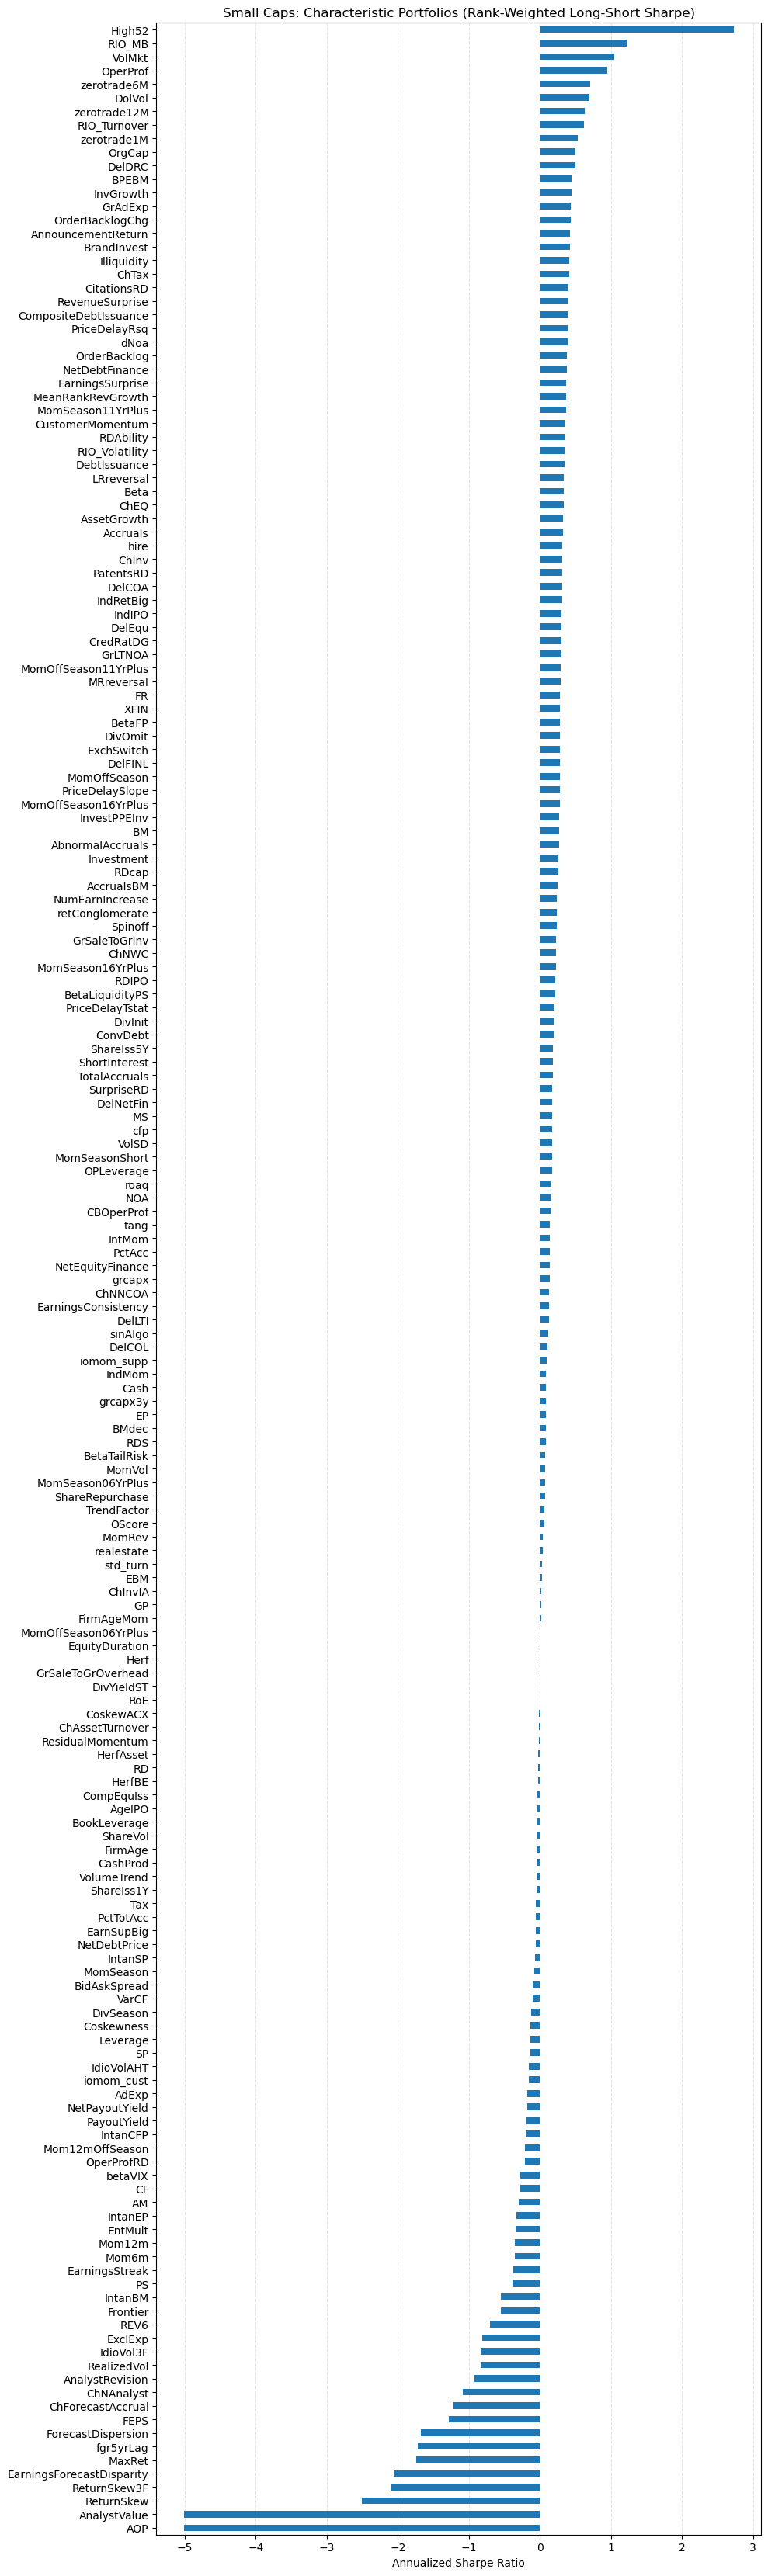

In [17]:
# Build portfolio return series for EVERY characteristic
# (Make this cell runnable even if you didn't run prior cells)
rank_cols = [c for c in df_small_ranks.columns if c.endswith('_rank')]

if 'characteristic_portfolio_returns' not in globals():
    def characteristic_portfolio_returns(df_small_ranks, rank_col, date_col="year_month", ret_col="ret"):
        tmp = df_small_ranks[[date_col, ret_col, rank_col]].dropna(subset=[ret_col, rank_col]).copy()
        tmp["w"] = tmp[rank_col] / 100.0 - 0.5
        tmp["wr"] = tmp["w"] * tmp[ret_col]
        tmp["absw"] = tmp["w"].abs()
        g = tmp.groupby(date_col, sort=True)
        return g["wr"].sum() / g["absw"].sum()

port_rets_small = {}
for rc in rank_cols:
    port_rets_small[rc.replace("_rank","")] = characteristic_portfolio_returns(df_small_ranks, rc)

# Convert dict of Series to DataFrame, aligning by index
port_rets_small = pd.concat(port_rets_small, axis=1).sort_index()
port_rets_small.head()

# Compute Annualized Sharpe ratios
sharpe_small = port_rets_small.mean() / port_rets_small.std(ddof=1) * np.sqrt(12)
sharpe_small = sharpe_small.dropna().sort_values()

# Plot Sharpe ratios
plt.figure(figsize=(10, max(6, 0.18 * len(sharpe_small))))
ax = sharpe_small.plot(kind="barh")
ax.set_axisbelow(True)
ax.grid(axis="x", linestyle="--", alpha=0.35)
plt.xlabel("Annualized Sharpe Ratio")
plt.title("Small Caps: Characteristic Portfolios (Rank-Weighted Long-Short Sharpe)")
plt.tight_layout()
plt.show()


In [18]:
warnings.filterwarnings("ignore")

df_small_ml = df_small.copy()
df_small_ml = df_small_ml.sort_values("year_month").reset_index(drop=True)

# Ensure numeric
df_small_ml["ret"] = pd.to_numeric(df_small_ml["ret"], errors="coerce")
df_small_ml[characteristic_cols_small] = df_small_ml[characteristic_cols_small].apply(pd.to_numeric, errors="coerce")

# Only drop rows where returns are NaN
df_small_ml = df_small_ml.dropna(subset=["ret"]).copy()

# Cross-sectional rank-normalize characteristics each month to [-0.5, 0.5]
df_small_ml[characteristic_cols_small] = (
    df_small_ml.groupby("year_month")[characteristic_cols_small]
               .rank(pct=True, na_option="keep")
    - 0.5
)

# Define train/validation/test split points (by year-month)
unique_months_small = sorted(df_small_ml["year_month"].dropna().unique())
total_months_small = len(unique_months_small)

train_end_idx = 20 * 12
val_end_idx = train_end_idx + 12 * 12

# Use idx-1 so train is exactly 240 months (same for validation)
train_end_date_small = unique_months_small[min(train_end_idx - 1, total_months_small - 1)]
val_end_date_small   = unique_months_small[min(val_end_idx   - 1, total_months_small - 1)]

# Create boolean masks for train/val/test
train_mask_small = df_small_ml["year_month"] <= train_end_date_small
val_mask_small   = (df_small_ml["year_month"] > train_end_date_small) & (df_small_ml["year_month"] <= val_end_date_small)
test_mask_small  = df_small_ml["year_month"] > val_end_date_small

# Extract data
X_train_raw_small = df_small_ml.loc[train_mask_small, characteristic_cols_small].values
y_train_small = df_small_ml.loc[train_mask_small, "ret"].values

X_val_raw_small = df_small_ml.loc[val_mask_small, characteristic_cols_small].values
y_val_small = df_small_ml.loc[val_mask_small, "ret"].values

X_test_raw_small = df_small_ml.loc[test_mask_small, characteristic_cols_small].values
y_test_small = df_small_ml.loc[test_mask_small, "ret"].values

# Impute missing ranks with 0 (middle of the cross-section); no StandardScaler needed now
imputer_small = SimpleImputer(strategy="constant", fill_value=0.0)
X_train_scaled_small = imputer_small.fit_transform(X_train_raw_small)
X_val_scaled_small   = imputer_small.transform(X_val_raw_small)
X_test_scaled_small  = imputer_small.transform(X_test_raw_small)

In [19]:
small_results = {}

BENCHMARK_SMALL = "train_mean"

# OLS
ols_model_small = LinearRegression()
ols_model_small.fit(X_train_scaled_small, y_train_small)

evaluate_model_oos(
    "OLS",
    ols_model_small,
    X_train_scaled_small,
    X_val_scaled_small,
    X_test_scaled_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)


MODEL: OLS

In-Sample:
  R² (sklearn):   0.212250
  RMSE:           0.290649

Validation Performance:
  R² (sklearn):   0.130655
  R²_OOS (train_mean):   0.137212
  RMSE:           0.155771

OOS:
  R²_OOS (train_mean):  -0.030433
  RMSE:           0.299720


{'r2_train': 0.21224998466498957,
 'r2_val': 0.13065508538632575,
 'r2_test_sklearn': -0.040304978689877924,
 'r2_oos_val': np.float64(0.13721151460848868),
 'r2_oos_test': np.float64(-0.03043346625526966),
 'rmse_train': np.float64(0.2906485817678322),
 'rmse_val': np.float64(0.155771148537134),
 'rmse_test': np.float64(0.2997203440151925),
 'model': LinearRegression()}

In [20]:
ridge_best_small = grid_search_on_val(
    Ridge,
    {"alpha": np.logspace(-5, 5, 25)},
    "Ridge",
    X_train_scaled_small,
    y_train_small,
    X_val_scaled_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

lasso_best_small = grid_search_on_val(
    Lasso,
    {"alpha": np.logspace(-6, -1, 25), "max_iter": [50000]},
    "Lasso",
    X_train_scaled_small,
    y_train_small,
    X_val_scaled_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

enet_best_small = grid_search_on_val(
    ElasticNet,
    {"alpha": np.logspace(-6, -1, 25), "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], "max_iter": [50000]},
    "ElasticNet",
    X_train_scaled_small,
    y_train_small,
    X_val_scaled_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

# Evaluate best models (stores into `small_results`)
evaluate_model_oos(
    "Ridge(best)",
    ridge_best_small["model"],
    X_train_scaled_small,
    X_val_scaled_small,
    X_test_scaled_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

evaluate_model_oos(
    "Lasso(best)",
    lasso_best_small["model"],
    X_train_scaled_small,
    X_val_scaled_small,
    X_test_scaled_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

evaluate_model_oos(
    "ElasticNet(best)",
    enet_best_small["model"],
    X_train_scaled_small,
    X_val_scaled_small,
    X_test_scaled_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

Ridge best: {'alpha': np.float64(316.22776601683796)} val R2_OOS: 0.2886073521660044
Lasso best: {'alpha': np.float64(0.005623413251903491), 'max_iter': 50000} val R2_OOS: 0.2922232396677158
ElasticNet best: {'alpha': np.float64(0.014677992676220705), 'l1_ratio': 0.3, 'max_iter': 50000} val R2_OOS: 0.29732988242945146

MODEL: Ridge(best)

In-Sample:
  R² (sklearn):   0.170308
  RMSE:           0.298286

Validation Performance:
  R² (sklearn):   0.283201
  R²_OOS (train_mean):   0.288607
  RMSE:           0.141446

OOS:
  R²_OOS (train_mean):   0.093721
  RMSE:           0.281085

MODEL: Lasso(best)

In-Sample:
  R² (sklearn):   0.166396
  RMSE:           0.298988

Validation Performance:
  R² (sklearn):   0.286845
  R²_OOS (train_mean):   0.292223
  RMSE:           0.141086

OOS:
  R²_OOS (train_mean):   0.085360
  RMSE:           0.282378

MODEL: ElasticNet(best)

In-Sample:
  R² (sklearn):   0.163768
  RMSE:           0.299459

Validation Performance:
  R² (sklearn):   0.291990
  R²_

{'r2_train': 0.16376770042400646,
 'r2_val': 0.29199021115383206,
 'r2_test_sklearn': 0.08052061920789955,
 'r2_oos_val': np.float64(0.29732988242945146),
 'r2_oos_test': np.float64(0.08924561075055837),
 'rmse_train': np.float64(0.29945906695923474),
 'rmse_val': np.float64(0.1405758098675845),
 'rmse_test': np.float64(0.281777869589851),
 'model': ElasticNet(alpha=np.float64(0.014677992676220705), l1_ratio=0.3, max_iter=50000)}

In [21]:
# RBF features
rbf_transformer_small = RBFSampler(n_components=100, gamma=1.0, random_state=42)
X_train_rbf_small = rbf_transformer_small.fit_transform(X_train_scaled_small)
X_val_rbf_small = rbf_transformer_small.transform(X_val_scaled_small)
X_test_rbf_small = rbf_transformer_small.transform(X_test_scaled_small)

# Grid search ON the RBF features (important: pass X_train_rbf / X_val_rbf)
ridge_rbf_best_small = grid_search_on_val(
    Ridge,
    {"alpha": np.logspace(-5, 5, 25)},
    "Ridge+RBF",
    X_train_rbf_small,
    y_train_small,
    X_val_rbf_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

lasso_rbf_best_small = grid_search_on_val(
    Lasso,
    {"alpha": np.logspace(-6, -1, 25), "max_iter": [50000]},
    "Lasso+RBF",
    X_train_rbf_small,
    y_train_small,
    X_val_rbf_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

enet_rbf_best_small = grid_search_on_val(
    ElasticNet,
    {"alpha": np.logspace(-6, -1, 25), "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 1.0], "max_iter": [50000]},
    "ElasticNet+RBF",
    X_train_rbf_small,
    y_train_small,
    X_val_rbf_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

# Evaluate
evaluate_model_oos(
    "Ridge+RBF(best)",
    ridge_rbf_best_small["model"],
    X_train_rbf_small,
    X_val_rbf_small,
    X_test_rbf_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

evaluate_model_oos(
    "Lasso+RBF(best)",
    lasso_rbf_best_small["model"],
    X_train_rbf_small,
    X_val_rbf_small,
    X_test_rbf_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

evaluate_model_oos(
    "ElasticNet+RBF(best)",
    enet_rbf_best_small["model"],
    X_train_rbf_small,
    X_val_rbf_small,
    X_test_rbf_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

Ridge+RBF best: {'alpha': np.float64(121.15276586285901)} val R2_OOS: 0.025286209214275157
Lasso+RBF best: {'alpha': np.float64(0.0005108969774506929), 'max_iter': 50000} val R2_OOS: 0.021113327499425072
ElasticNet+RBF best: {'alpha': np.float64(0.003480700588428413), 'l1_ratio': 0.1, 'max_iter': 50000} val R2_OOS: 0.024615737633327806

MODEL: Ridge+RBF(best)

In-Sample:
  R² (sklearn):   0.019335
  RMSE:           0.324291

Validation Performance:
  R² (sklearn):   0.017879
  R²_OOS (train_mean):   0.025286
  RMSE:           0.165567

OOS:
  R²_OOS (train_mean):   0.001048
  RMSE:           0.295106

MODEL: Lasso+RBF(best)

In-Sample:
  R² (sklearn):   0.017994
  RMSE:           0.324512

Validation Performance:
  R² (sklearn):   0.013675
  R²_OOS (train_mean):   0.021113
  RMSE:           0.165921

OOS:
  R²_OOS (train_mean):  -0.000286
  RMSE:           0.295303

MODEL: ElasticNet+RBF(best)

In-Sample:
  R² (sklearn):   0.019760
  RMSE:           0.324220

Validation Performance:
  

{'r2_train': 0.01976043246551873,
 'r2_val': 0.017203680114135533,
 'r2_test_sklearn': -0.009443353505099727,
 'r2_oos_val': np.float64(0.024615737633327806),
 'r2_oos_test': np.float64(0.00013531123291510294),
 'rmse_train': np.float64(0.32422023216751134),
 'rmse_val': np.float64(0.16562379206186092),
 'rmse_test': np.float64(0.29524113101327387),
 'model': ElasticNet(alpha=np.float64(0.003480700588428413), l1_ratio=0.1, max_iter=50000)}

In [22]:
pls_best_small = grid_search_on_val(
    PLSRegression,
    {"n_components": list(range(1, min(50, X_train_scaled_small.shape[1]) + 1, 5))},
    "PLS(Linear)",
    X_train_scaled_small,
    y_train_small,
    X_val_scaled_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

evaluate_model_oos(
    "PLS(linear)",
    pls_best_small["model"],
    X_train_scaled_small,
    X_val_scaled_small,
    X_test_scaled_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

# Non-Linear expansion

rbf_transformer_pls_small = RBFSampler(n_components=100, gamma=1.0, random_state=42)
X_train_rbf_pls_small = rbf_transformer_pls_small.fit_transform(X_train_scaled_small)
X_val_rbf_pls_small = rbf_transformer_pls_small.transform(X_val_scaled_small)
X_test_rbf_pls_small = rbf_transformer_pls_small.transform(X_test_scaled_small)

X_train_combined_small = np.concatenate([X_train_scaled_small, X_train_rbf_pls_small], axis=1)
X_val_combined_small = np.concatenate([X_val_scaled_small, X_val_rbf_pls_small], axis=1)
X_test_combined_small = np.concatenate([X_test_scaled_small, X_test_rbf_pls_small], axis=1)

pls_rbf_best_small = grid_search_on_val(
    PLSRegression,
    {"n_components": list(range(1, min(50, X_train_combined_small.shape[1]) + 1, 5))},
    # Try [1, 6, 11, 16, 21, 26, 31, 36, 41, 46] components
    "PLS(linear+RBF)",
    X_train_combined_small,
    y_train_small,
    X_val_combined_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

evaluate_model_oos(
    "PLS(linear+RBF)(best)",
    pls_rbf_best_small["model"],
    X_train_combined_small,
    X_val_combined_small,
    X_test_combined_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

PLS(Linear) best: {'n_components': 6} val R2_OOS: 0.14736854967481539

MODEL: PLS(linear)

In-Sample:
  R² (sklearn):   0.209811
  RMSE:           0.291098

Validation Performance:
  R² (sklearn):   0.140889
  R²_OOS (train_mean):   0.147369
  RMSE:           0.154852

OOS:
  R²_OOS (train_mean):  -0.035633
  RMSE:           0.300476
PLS(linear+RBF) best: {'n_components': 16} val R2_OOS: 0.0912736891087047

MODEL: PLS(linear+RBF)(best)

In-Sample:
  R² (sklearn):   0.226271
  RMSE:           0.288050

Validation Performance:
  R² (sklearn):   0.084368
  R²_OOS (train_mean):   0.091274
  RMSE:           0.159864

OOS:
  R²_OOS (train_mean):  -0.061629
  RMSE:           0.304223


{'r2_train': 0.22627096844203742,
 'r2_val': 0.08436817305169286,
 'r2_test_sklearn': -0.07179953307710307,
 'r2_oos_val': np.float64(0.0912736891087047),
 'r2_oos_test': np.float64(-0.06162916704511301),
 'rmse_train': np.float64(0.2880503745574423),
 'rmse_val': np.float64(0.15986426789689884),
 'rmse_test': np.float64(0.3042234350177854),
 'model': PLSRegression(n_components=16)}

In [23]:
gb_best_small = grid_search_on_val(
    GradientBoostingRegressor,
    {
        "n_estimators": [100, 300],
        "learning_rate": [0.05, 0.1],
        "max_depth": [2, 3],
        "min_samples_leaf": [20, 50],
        "subsample": [0.6, 0.8],
        "max_features": ["sqrt"],
        "random_state": [42],
    },
    "GradientBoosting",
    X_train_scaled_small,
    y_train_small,
    X_val_scaled_small,
    y_val_small,
    benchmark=BENCHMARK_SMALL,
)

# Evaluate
evaluate_model_oos(
    "GradientBoosting(best)",
    gb_best_small["model"],
    X_train_scaled_small,
    X_val_scaled_small,
    X_test_scaled_small,
    y_train_small,
    y_val_small,
    y_test_small,
    small_results,
    benchmark=BENCHMARK_SMALL,
)

GradientBoosting best: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.8} val R2_OOS: 0.22646281408161728

MODEL: GradientBoosting(best)

In-Sample:
  R² (sklearn):   0.347121
  RMSE:           0.264600

Validation Performance:
  R² (sklearn):   0.220585
  R²_OOS (train_mean):   0.226463
  RMSE:           0.147494

OOS:
  R²_OOS (train_mean):   0.040624
  RMSE:           0.289202


{'r2_train': 0.34712063032053775,
 'r2_val': 0.22058461577918675,
 'r2_test_sklearn': 0.0314334035531475,
 'r2_oos_val': np.float64(0.22646281408161728),
 'r2_oos_test': np.float64(0.04062418644511456),
 'rmse_train': np.float64(0.26460038439547584),
 'rmse_val': np.float64(0.14749437228751985),
 'rmse_test': np.float64(0.2892015574994215),
 'model': GradientBoostingRegressor(learning_rate=0.05, max_features='sqrt',
                           min_samples_leaf=50, random_state=42, subsample=0.8)}

In [24]:
rows = []
for name, metrics in small_results.items():
    row = {"model": name}

    for k, v in metrics.items():
        if k == "model":
            row["estimator"] = type(v).__name__
            row["params"] = getattr(v, "get_params", lambda: {})()
        else:
            row[k] = float(v) if isinstance(v, (np.floating, np.integer)) else v

    rows.append(row)

df_small_results = pd.DataFrame(rows)

# Put the most common columns first (others will follow)
first_cols = [c for c in ["model", "estimator", "r2_oos_test", "r2_oos_val", "r2_test_sklearn", "r2_val", "r2_train",
                          "rmse_test", "rmse_val", "rmse_train", "params"] if c in df_small_results.columns]
df_small_results = df_small_results[first_cols + [c for c in df_small_results.columns if c not in first_cols]]

# Sort best-to-worst (change key if you want)
sort_key = "r2_oos_test" if "r2_oos_test" in df_small_results.columns else "r2_oos_val"
df_small_results = df_small_results.sort_values(sort_key, ascending=False).reset_index(drop=True)
df_small_results


,model,estimator,r2_oos_test,r2_oos_val,r2_test_sklearn,r2_val,r2_train,rmse_test,rmse_val,rmse_train,params
0,Ridge(best),Ridge,0.093721,0.288607,0.085039,0.283201,0.170308,0.281085,0.141446,0.298286,"{'alpha': 316.22776601683796, 'copy_X': True, ..."
1,ElasticNet(best),ElasticNet,0.089246,0.297330,0.080521,0.291990,0.163768,0.281778,0.140576,0.299459,"{'alpha': 0.014677992676220705, 'copy_X': True..."
2,Lasso(best),Lasso,0.085360,0.292223,0.076598,0.286845,0.166396,0.282378,0.141086,0.298988,"{'alpha': 0.005623413251903491, 'copy_X': True..."
3,GradientBoosting(best),GradientBoostingRegressor,0.040624,0.226463,0.031433,0.220585,0.347121,0.289202,0.147494,0.264600,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ..."
4,Ridge+RBF(best),Ridge,0.001048,0.025286,-0.008522,0.017879,0.019335,0.295106,0.165567,0.324291,"{'alpha': 121.15276586285901, 'copy_X': True, ..."
5,ElasticNet+RBF(best),ElasticNet,0.000135,0.024616,-0.009443,0.017204,0.019760,0.295241,0.165624,0.324220,"{'alpha': 0.003480700588428413, 'copy_X': True..."
6,Lasso+RBF(best),Lasso,-0.000286,0.021113,-0.009868,0.013675,0.017994,0.295303,0.165921,0.324512,"{'alpha': 0.0005108969774506929, 'copy_X': Tru..."
7,OLS,LinearRegression,-0.030433,0.137212,-0.040305,0.130655,0.212250,0.299720,0.155771,0.290649,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
8,PLS(linear),PLSRegression,-0.035633,0.147369,-0.045554,0.140889,0.209811,0.300476,0.154852,0.291098,"{'copy': True, 'max_iter': 500, 'n_components'..."
9,PLS(linear+RBF)(best),PLSRegression,-0.061629,0.091274,-0.071800,0.084368,0.226271,0.304223,0.159864,0.288050,"{'copy': True, 'max_iter': 500, 'n_components'..."


In [25]:

# test-period panel aligned with small X_test_* row order
df_small_test = (
    df_small_ml.loc[test_mask_small, ["permno", "year_month", "ret"]]
    .copy()
    .reset_index(drop=True)
)
df_small_test["ret"] = pd.to_numeric(df_small_test["ret"], errors="coerce")
df_small_test = df_small_test.dropna(subset=["ret"]).reset_index(drop=True)

# build RBF / combined features (fit on small train only)
rbf_transformer_small = RBFSampler(n_components=100, gamma=1.0, random_state=42)
_ = rbf_transformer_small.fit_transform(X_train_scaled_small)

X_test_rbf_small = rbf_transformer_small.transform(X_test_scaled_small)
X_test_combined_small = np.hstack([X_test_scaled_small, X_test_rbf_small])

def X_for_model_name_small(name):
    n = name.lower()
    if "linear+rbf" in n or "combined" in n:
        return X_test_combined_small
    if "rbf" in n:
        return X_test_rbf_small
    return X_test_scaled_small

# ML portfolios (from small_results)
ml_port_rets_small = {}
for model_name, m in small_results.items():
    model = m["model"]
    X_use = X_for_model_name_small(model_name)
    preds = np.asarray(model.predict(X_use)).ravel()

    df_scores = df_small_test.copy()
    df_scores["score"] = preds
    ml_port_rets_small[model_name] = long_short_portfolio_returns(df_scores, "score")

ml_port_rets_small = pd.DataFrame(ml_port_rets_small).sort_index()
ml_sharpe_small = (ml_port_rets_small.apply(ann_sharpe)).sort_values(ascending=False)

# characteristic portfolios Sharpe over SAME test months
test_months_small = ml_port_rets_small.index
char_port_rets_small_test = port_rets_small.loc[port_rets_small.index.intersection(test_months_small)].copy()
char_sharpe_small = (char_port_rets_small_test.apply(ann_sharpe)).sort_values(ascending=False)

# comparison tables
df_ml_sharpe_small = ml_sharpe_small.rename("ann_sharpe").to_frame()
df_char_sharpe_small = char_sharpe_small.rename("ann_sharpe").to_frame()

print("Top SmallML ML portfolios (annualized Sharpe):")
display(df_ml_sharpe_small)

print("Top SmallML characteristic portfolios over same period (annualized Sharpe):")
display(df_char_sharpe_small.head(20))


Top SmallML ML portfolios (annualized Sharpe):


,ann_sharpe
ElasticNet(best),3.030037
Lasso(best),2.993730
Ridge(best),2.840307
OLS,2.598551
PLS(linear),2.562165
PLS(linear+RBF)(best),2.542413
GradientBoosting(best),2.334398
Ridge+RBF(best),0.431129
ElasticNet+RBF(best),0.364587
Lasso+RBF(best),0.209680


Top SmallML characteristic portfolios over same period (annualized Sharpe):


,ann_sharpe
High52,2.249024
RIO_MB,1.216589
TrendFactor,0.991175
OperProf,0.950469
VolMkt,0.883493
DolVol,0.737142
zerotrade6M,0.644184
zerotrade12M,0.536129
OrgCap,0.515244
DelDRC,0.496549


## Analysis 

(a) The best characteristics perform similarly in both large-cap and small-cap universes. This means that certain quality factors work in both universes. For example, the characteristic Hgm52 are both at the top.

(b) the ML models still show some out-of-sample predictability in small caps, but the effect is modest. The best linear regularized models (Ridge/Lasso/ElasticNet) achieve test OOS R^2 of roughly 0.085–0.094, while GradientBoosting is lower at about 0.041. In contrast, the RBF-based nonlinear expansions add little, and OLS/PLS perform poorly out-of-sample. Relative to the earlier models (where test OOS R^2 was closer to 0.12–0.14 for the top models), these results suggest the apparent predictability is sensitive to the feature construction/tuning and may partly reflect instability or overfitting in the earlier setup.

(c) Large caps deliver higher long-short Sharpe for the ML portfolios, and ML beats the best characteristic portfolios in both universes. This makes sense because Sharpe is dependent on volatility. On the other hand, OOS forecasting rewards accuracy. Large caps have lower return volatility and more stable ranks, and therefore produces higher Sharpe even if R^2 is near zero. 


## (e) Highest possible Sharpe ratio OOS

In [26]:
# we use large, because large-cap stocks had overall higher Sharpe ratios
USE = "large"
K = 3
N = 5000

if USE == "large":
    MODELS = results
    DF_PANEL = df_ml
    val_mask_u = val_mask
    test_mask_u = test_mask
    X_train_scaled_u = X_train_scaled
    X_val_scaled_u = X_val_scaled
    X_test_scaled_u = X_test_scaled
elif USE == "small":
    MODELS = small_results
    DF_PANEL = df_small_ml
    val_mask_u = val_mask_small
    test_mask_u = test_mask_small
    X_train_scaled_u = X_train_scaled_small
    X_val_scaled_u = X_val_scaled_small
    X_test_scaled_u = X_test_scaled_small
else:
    raise ValueError("USE must be 'large' or 'small'")

# Build aligned panels
val_mask_arr = np.asarray(val_mask_u)
test_mask_arr = np.asarray(test_mask_u)
assert len(val_mask_arr) == len(DF_PANEL), (len(val_mask_arr), len(DF_PANEL))
assert len(test_mask_arr) == len(DF_PANEL), (len(test_mask_arr), len(DF_PANEL))

df_val = DF_PANEL.iloc[val_mask_arr][["permno", "year_month", "ret"]].copy().reset_index(drop=True)
df_test = DF_PANEL.iloc[test_mask_arr][["permno", "year_month", "ret"]].copy().reset_index(drop=True)
df_val["ret"] = pd.to_numeric(df_val["ret"], errors="coerce")
df_test["ret"] = pd.to_numeric(df_test["ret"], errors="coerce")
df_val = df_val.dropna(subset=["ret"]).reset_index(drop=True)
df_test = df_test.dropna(subset=["ret"]).reset_index(drop=True)

assert len(df_val) == X_val_scaled_u.shape[0], (len(df_val), X_val_scaled_u.shape[0])
assert len(df_test) == X_test_scaled_u.shape[0], (len(df_test), X_test_scaled_u.shape[0])

# Feature sets for models trained on RBF / combined
rbf = RBFSampler(n_components=100, gamma=1.0, random_state=42)
_ = rbf.fit_transform(X_train_scaled_u)
X_val_rbf = rbf.transform(X_val_scaled_u)
X_test_rbf = rbf.transform(X_test_scaled_u)
X_val_combined = np.hstack([X_val_scaled_u, X_val_rbf])
X_test_combined = np.hstack([X_test_scaled_u, X_test_rbf])

def X_for_model_name(name, split="val"):
    n = name.lower()
    if split == "val":
        if "linear+rbf" in n or "combined" in n:
            return X_val_combined
        if "rbf" in n:
            return X_val_rbf
        return X_val_scaled_u
    else:
        if "linear+rbf" in n or "combined" in n:
            return X_test_combined
        if "rbf" in n:
            return X_test_rbf
        return X_test_scaled_u

def cs_rank(s):
    return s.rank(pct=True) - 0.5

# 1) Score each model on VALIDATION Sharpe (rank-normalized)
model_val_scores = {}
model_val_sharpes = {}
for model_name, d in MODELS.items():
    pred_val = np.asarray(d["model"].predict(X_for_model_name(model_name, "val"))).ravel()
    tmp = df_val.copy()
    tmp["pred"] = pred_val
    tmp["pred_rank"] = tmp.groupby("year_month")["pred"].transform(cs_rank)
    val_rets = long_short_portfolio_returns(tmp.rename(columns={"pred_rank": "score"}), "score")
    model_val_scores[model_name] = tmp["pred_rank"].values
    model_val_sharpes[model_name] = ann_sharpe(val_rets)

val_rank = pd.Series(model_val_sharpes).sort_values(ascending=False)
display(val_rank.head(10).to_frame("val_ann_sharpe"))

top_models = list(val_rank.head(K).index)
print("Ensembling:", top_models)

# 2) Weight search to maximize VALIDATION Sharpe
S_val = np.column_stack([model_val_scores[m] for m in top_models])
rng = np.random.default_rng(42)
W = rng.dirichlet(np.ones(K), size=N)
best = {"sharpe": -np.inf, "w": None}
for w in W:
    tmp = df_val.copy()
    tmp["score"] = S_val @ w
    sh = ann_sharpe(long_short_portfolio_returns(tmp, "score"))
    if sh > best["sharpe"]:
        best = {"sharpe": sh, "w": w}

print("Best val Sharpe:", best["sharpe"])
print("Weights:", {m: float(w) for m, w in zip(top_models, best["w"])})

# 3) Evaluate ensemble on TEST
S_test_list = []
for m in top_models:
    pred_test = np.asarray(MODELS[m]["model"].predict(X_for_model_name(m, "test"))).ravel()
    tmp = df_test.copy()
    tmp["pred"] = pred_test
    tmp["pred_rank"] = tmp.groupby("year_month")["pred"].transform(cs_rank)
    S_test_list.append(tmp["pred_rank"].values)

S_test = np.column_stack(S_test_list)
tmp = df_test.copy()
tmp["score"] = S_test @ best["w"]
ens_test_rets = long_short_portfolio_returns(tmp, "score")
print("Ensemble TEST annualized Sharpe:", ann_sharpe(ens_test_rets))
display(ens_test_rets.rename("ensemble_ret").to_frame().head())


,val_ann_sharpe
ElasticNet(best),4.410534
Ridge(best),4.407544
Elastic Net,4.330785
Lasso(best),4.262187
Ridge,4.116505
GradientBoosting(best),3.803762
OLS,3.607586
PLS(linear+RBF)(best),2.589066
PLS(linear),2.520789
Lasso,1.340154


Ensembling: ['ElasticNet(best)', 'Ridge(best)', 'Elastic Net']
Best val Sharpe: 4.509862596149038
Weights: {'ElasticNet(best)': 0.5176989195245557, 'Ridge(best)': 0.20159523663094933, 'Elastic Net': 0.280705843844495}
Ensemble TEST annualized Sharpe: 8.187265118227053


,ensemble_ret
year_month,
1967-07-01,0.088088
1967-08-01,0.039988
1967-10-01,0.063449
1967-11-01,0.043151
1968-01-01,0.023733


## Strategy + Analysis

I run every model and score it based on its validation set by simulating a long-short portfolio. I then pick the top 3 models (K=3) by validation Sharpe. The intuition is that ensemble methods tend to work best when you combine a small number of strong models rather than averaging everything together. I then search for the best combination weights across those 3 models instead of equal-weighting them — randomly sampling N=5000 weight combinations from a Dirichlet distribution and picking the combination that maximizes validation Sharpe. I then take those weights and apply them to the test set without any further tuning.

Based on my results, the top 3 models are Elastic Net(best), Elastic Net, and Lasso. This mix achieves a validation Sharpe of 4.5 and an annualized test Sharpe of 8.19, which is a notably stronger OOS result. This suggests that the ensemble generalizes well rather than overfitting to the validation period.